# W207 Facial Keynotes

#Team 

Members:
- Tucker Anderson
- Bruno Todescan
- Madia Taher

# EDA

duplicate
check preprocessing
pair dropping
how can we check outliers? 



In [68]:
#import libraries
from tensorflow import keras as keras
import tensorflow as tf
import csv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline



In [69]:
lookid_data = pd.read_csv("IdLookupTable.csv")
lookid_data.head()

FileNotFoundError: File b'IdLookupTable.csv' does not exist

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
samplesubmission = pd.read_csv("SampleSubmission.csv")
samplesubmission.head()

In [ ]:
train_data = pd.read_csv("training.csv")
train_data.head().T


In [ ]:
train_data['Image']

In [ ]:
test_data = pd.read_csv("test.csv")
test_data.head()

In [ ]:
train_data.isnull().sum()

In [ ]:
print(train_data.count())# prints the number of values for each column
print(len(train_data))
df = train_data.dropna()  # drop all rows that have missing values in them
len(df)

In [ ]:
IMAGE_WIDTH = 96
IMAGE_HEIGHT = 96

In [ ]:
def load_dataset():

    Xtrain = []
    Ytrain = []
    with open('training.csv') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            img = np.zeros((IMAGE_HEIGHT,IMAGE_WIDTH,1), dtype=np.float)
            for i, val in enumerate(row["Image"].split(" ")):
                img[i//IMAGE_WIDTH,i%IMAGE_WIDTH,0] = val
            Yitem = []
            failed = False
            for coord in row:
                if coord == "Image":
                    continue
                if(row[coord].strip()==""):
                    failed = True
                    break
                Yitem.append(float(row[coord]))
            if not failed:
                Xtrain.append(img)
                Ytrain.append(Yitem)
                
    return np.array(Xtrain), np.array(Ytrain, dtype=np.float)

In [ ]:
Xdata, Ydata = load_dataset()
Xtrain = Xdata[:]
Ytrain = Ydata[:]
Xtrain[10]

In [72]:
# Load test data
def load_testset():
    Xtest = []
    with open('test.csv') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            img = np.zeros((IMAGE_HEIGHT,IMAGE_WIDTH,1), dtype=np.float)
            for i, val in enumerate(row["Image"].split(" ")):
                img[i//IMAGE_WIDTH,i%IMAGE_WIDTH,0] = val
            Xtest.append(img)
                
    return np.array(Xtest)
Xtest = load_testset()

FileNotFoundError: [Errno 2] No such file or directory: 'test.csv'

In [ ]:
def show_image(X, Y):
    img = np.copy(X)
    for i in range(0,Y.shape[0],2):
        if 0 < Y[i+1] < IMAGE_HEIGHT and 0 < Y[i] < IMAGE_WIDTH:
            img[int(Y[i+1]),int(Y[i]),0] = 255
    plt.imshow(img[:,:,0])

In [ ]:
show_image(Xtrain[2], Ytrain[2])

### Pixel Value Distributions

To get an idea about our data set, we can see what the densities are like for the image set. This can be accomplished by summing all the pixel values and plotting these. The imshow() command will automatically scale these representing a density plot.

In [71]:
# To look at image densities, we "overlay" them by summing all the values at each pixel. 
# Higher values will show higher densities overall.

pixel_sums_train = np.zeros((96,96))
pixel_sums_test = np.zeros((96,96))

for r in range(96):
    for c in range(96):
        pixel_sums_train[r,c] = np.sum(Xtrain[:,r,c,0]/255)
        pixel_sums_test[r,c] = np.sum(Xtest[:,r,c,0]/255)

plt.subplot(1,2,1)
plt.imshow(pixel_sums_train, cmap='viridis')
plt.subplot(1,2,2)
plt.imshow(pixel_sums_test, cmap='viridis')

NameError: name 'Xtest' is not defined

This plot shows a few interesting points. The forehead, eyes, nose and cheeks are quite distinct, meaning that the majority of our images are centered in approximately the same location. The blurring above the lips and around the mouth area is likely due to mustaches, smiles vs frowns, etc. We can also see that our training and test sets generated similar images, so we should expect our model to perform relatively well to the test data set, though generalizability is something we'll need to look out for.

Based on this, one could assume that the a model may be more accurate with predictions of where the eyes and nose are, while having poorer accuracy with the mouth and potentially the ends of the eyebrows.

### Facial Keypoints Distributions

To take a deeper look at our dataset, we investigate where we our keypoints generally lie. This will help to identify any outlier images, and reinfornce the observations made in the previous step with the heatmaps.

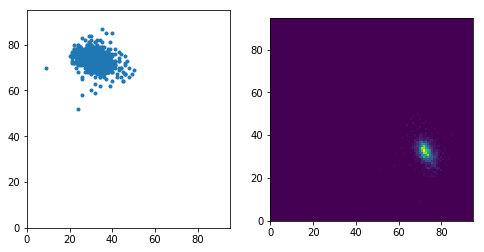

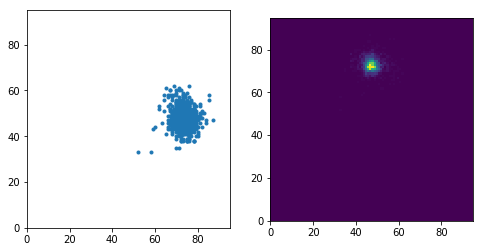

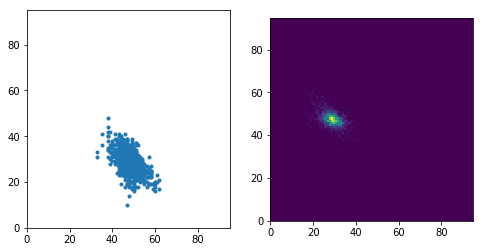

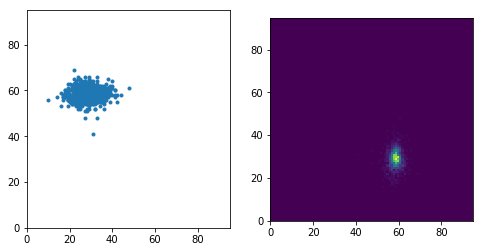

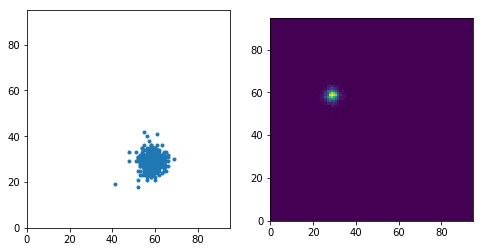

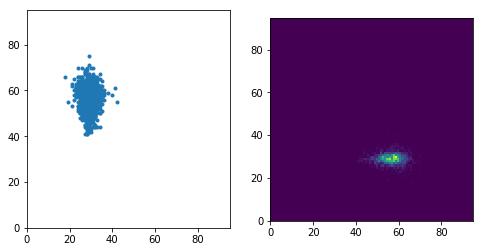

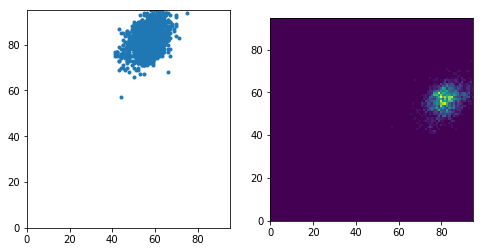

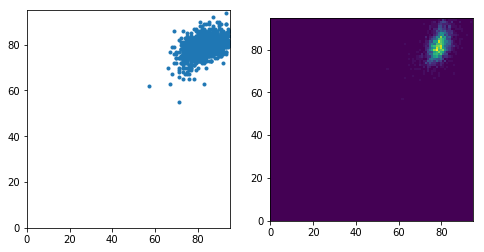

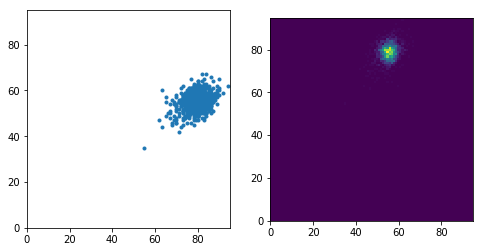

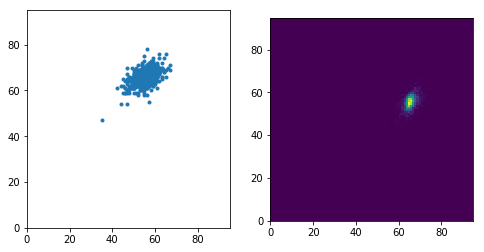

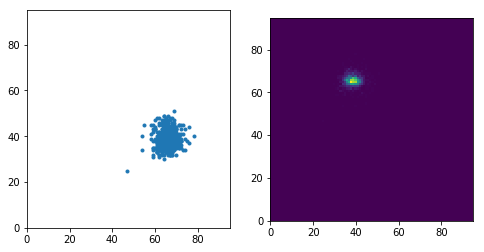

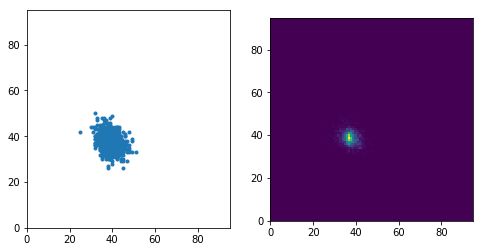

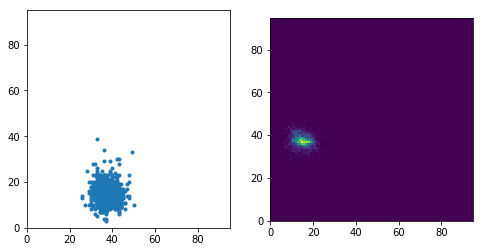

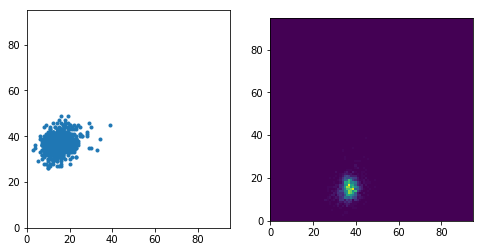

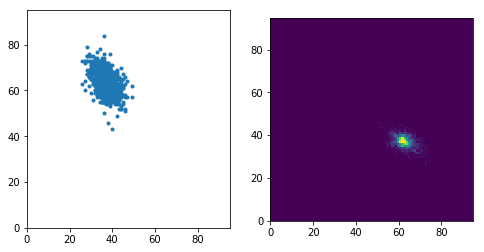

In [70]:
def get_feature_density(feature_ind, label_array):
    feature_density = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH))
    for i in range(len(label_array)):
        r = Ytrain[i,feature_ind]
        c = Ytrain[i,feature_ind+1]
        if ~np.isnan(r) and ~np.isnan(c):
            feature_density[int(r),int(c)] += 1
    return feature_density


for i in range(15):
    plt.figure(figsize=(8,4))
    ax1 = plt.subplot(1,2,1)
    ax1.scatter(x=Ytrain[:,i].astype('int8'), y=Ytrain[:,i+1].astype('int8'), marker='.')
    ax1.set_xlim(0,IMAGE_WIDTH-1)
    ax1.set_ylim(0,IMAGE_HEIGHT-1)

    ax2 = plt.subplot(1,2,2)
    ax2.imshow(get_feature_density(i,Ytrain), cmap='viridis')
    ax2.set_xlim(0,IMAGE_WIDTH-1)
    ax2.set_ylim(0,IMAGE_HEIGHT-1)

    plt.show()

We can see that the features are generally clustered around a point, with few outliers. This aligns with the findings above where we saw the "average" image for our data set.

In [ ]:
# Configure Model
model = keras.Sequential([keras.layers.Flatten(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH,1)),
                         keras.layers.Dense(128, activation="relu"),
                         keras.layers.Dropout(0.1),
                         keras.layers.Dense(64, activation="relu"),
                         keras.layers.Dense(30)
                         ])

In [ ]:
# Compile model
model.compile(optimizer=tf.train.AdamOptimizer, 
              loss='mse',
              metrics=['accuracy'])

In [0]:
# Train model
model.fit(Xtrain, Ytrain, epochs=50)

Epoch 1/50
2140/2140 [==============================] - 1s 404us/sample - loss: 13.8178 - acc: 0.7033
Epoch 2/50
2140/2140 [==============================] - 1s 371us/sample - loss: 10.1687 - acc: 0.7051
Epoch 3/50
2140/2140 [==============================] - 1s 366us/sample - loss: 10.1623 - acc: 0.7051
Epoch 4/50
2140/2140 [==============================] - 1s 367us/sample - loss: 10.1621 - acc: 0.7051
Epoch 5/50
2140/2140 [==============================] - 1s 365us/sample - loss: 10.1630 - acc: 0.7051
Epoch 6/50
2140/2140 [==============================] - 1s 368us/sample - loss: 10.1545 - acc: 0.7051
Epoch 7/50
2140/2140 [==============================] - 1s 366us/sample - loss: 10.1651 - acc: 0.7051
Epoch 8/50
2140/2140 [==============================] - 1s 367us/sample - loss: 10.1616 - acc: 0.7051
Epoch 9/50
2140/2140 [==============================] - 1s 367us/sample - loss: 10.1598 - acc: 0.7051
Epoch 10/50
2140/2140 [==============================] - 1s 373us/sample - loss: 1

In [0]:
def show_results(image_index):
    Ypred = model.predict(Xtest[image_index:(image_index+1)])
    show_image(Xtest[image_index], Ypred[0])

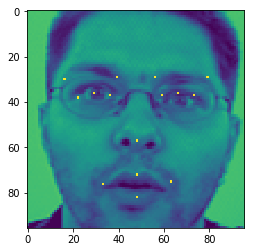

In [0]:
show_results(10)

In [48]:
show_results(6220)

NameError: ignored